In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
#f = r.TFile("./data/gm2lostMuonTree_full_run2timingoffsets.root")
#f = r.TFile("./data/gm2offline_full_allSubruns.root") # energy ending at 1000
#f = r.TFile("./data/gm2offline_full_allRuns_EnergyFix.root")
f = r.TFile("./data/gm2offline_full_26276471_29925.00031.root") #1 file with run3 templates
#f = r.TFile("./data/results_LostMuons_ForEnergyCalibration.root") #results of all lost muon runs with run3 templates.
f.cd("lostMuonTree")
f.ls()

t = f.Get("lostMuonTree/lostMuonCoincidences")
#t.Print()

TFile**		./data/gm2offline_full_26276471_29925.00031.root	
 TFile*		./data/gm2offline_full_26276471_29925.00031.root	
  TDirectoryFile*		lostMuonTree	lostMuonTree (LostMuonTree) folder
   KEY: TTree	lostMuonCoincidences;2	lostMuonCoincidences
   KEY: TTree	lostMuonCoincidences;1	lostMuonCoincidences
  KEY: TDirectoryFile	lostMuonTree;1	lostMuonTree (LostMuonTree) folder


In [3]:
#cutString = "coinNum == 1 && nHit == 1" #original
#cutString = "coinNum == 1 && nHit == 1"
cutString = "coinNum > 0 && coinNum < 4 && nHit == 1"

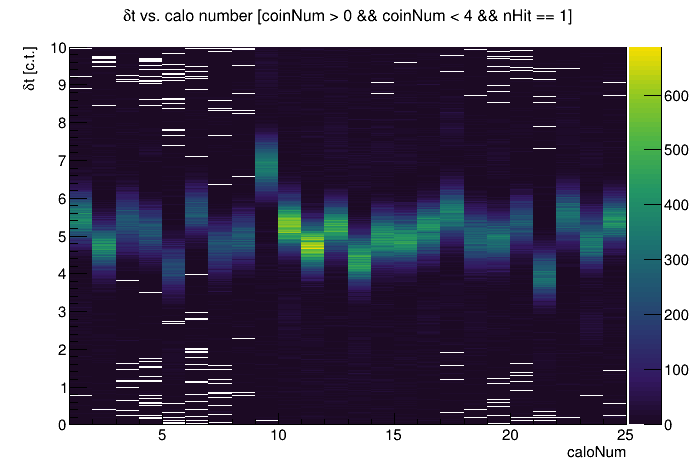

In [4]:
c = r.TCanvas()
deltaTCalos = r.TH2D("deltaTCalos","#deltat vs. calo number ["+str(cutString)+"]; caloNum; #deltat [c.t.]", 24,1,25,1000,0,10)
t.Draw("deltaT:caloNum>>deltaTCalos",cutString,"goff")
deltaTCalos.Draw("colz")
c.Draw()

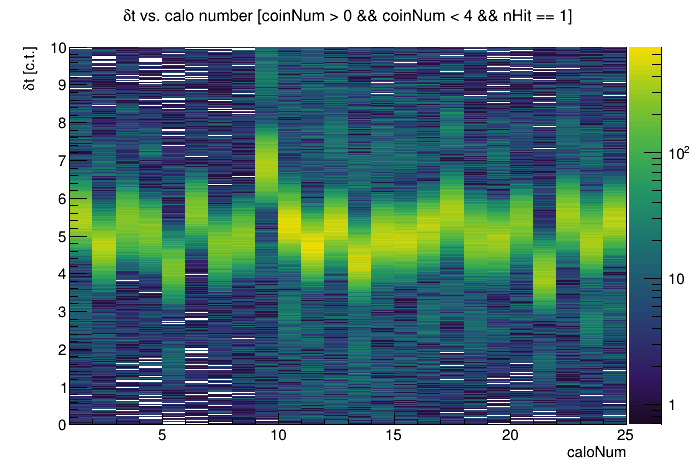

In [5]:
c = r.TCanvas()
deltaTCalos.Draw("colz")
c.Draw()
c.SetLogz()

#c.Print("./deltaTCalos.root")

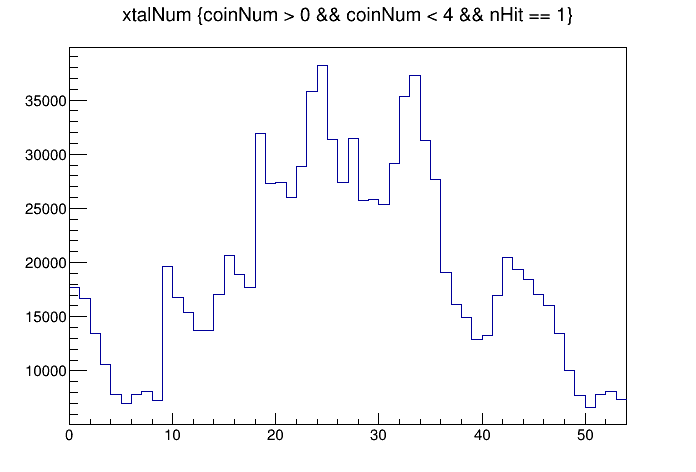

In [6]:
c = r.TCanvas()
t.Draw("xtalNum>>hist(54,0,54)", cutString)
c.Draw()

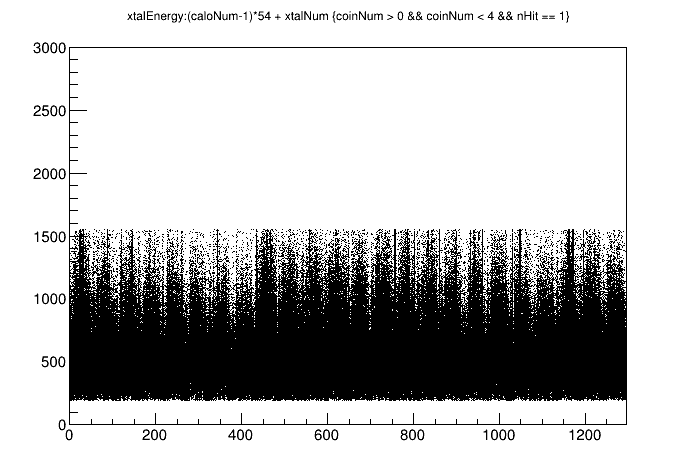

In [7]:
getHistFromFile = True

if(getHistFromFile):
    fhist = r.TFile("./data/xtalEnergy_vs_XtalNum_ForEnergyCalibration.root")
    c = fhist.Get("c1")
    allEnergies = c.GetPrimitive("energyXtal").Clone("energyXtal")
    allEnergies.SetDirectory(0)
else:
    allEnergies = r.TH2D("energyXtal","Xtal Energies; Xtal Number; Energy [MeV-ish]", 1296,-0.5,1295.5,400,0.0,3000.0)
    t.Draw("xtalEnergy:(caloNum-1)*54 + xtalNum>>energyXtal",cutString,"goff")

c = r.TCanvas()
allEnergies.Draw()
c.Draw()

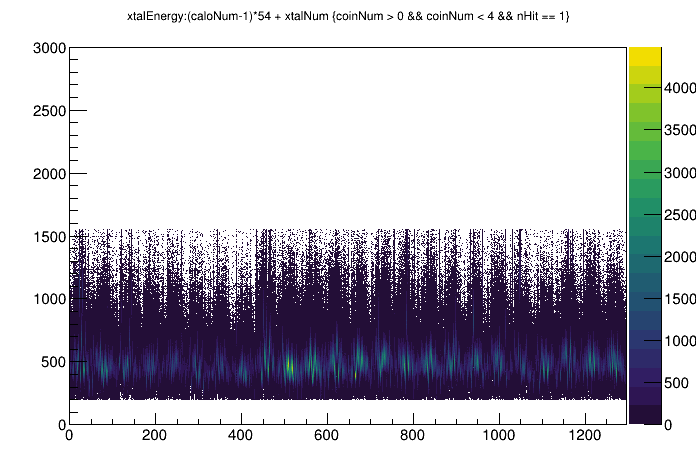

In [8]:
allEnergies.Draw("colz")
c.Draw()

In [9]:
targetE = 170.0 #MeV
scales = []
runningCalo = []
potentialLostCauses = []

uncalibratedAllXtals = r.TH1D("uncalibratedAllXtals","All crystals",100,0.0,1000.0)
calibratedXtals = r.TH1D("calibratedXtals","All crystals; Energy [MeV]; N / 5 MeV",100,0.0,1000.0)
calibratedXtalsFinal = r.TH1D("calibratedXtalsFinal","All crystals; Energy [MeV]; N / 5 MeV",100,0.0,1000.0)

#current bad xtals
ding = [ #(36, 100, 800)
       ]

#problemXtals = [3*54+6, 3*54 + 1, 5*54+47, 16*54 + 18, 16*54 + 27, 16*54 + 5, 16*54+4, 
#                16*54 + 45, 49, 45 + 54, 3*54 + 49, 8*54+18, 9*54+6, 11*54 + 2, 18*54 + 27, 
#                18*54 + 7, 21*54 + 4, 4*54 + 46, 47 + 54, 48+54, 5*54 + 47, 5*54 + 1]
#lower = [ 400, 375, 200, 450, 425, 350, 500, 350, 450, 150, 420, 350, 500, 450, 420, 420, 400, 200,350, 250, 200, 300]
#upper = [ 600, 575, 600, 450, 620, 600, 650, 550, 640, 850, 675, 600, 650, 750, 575, 600, 600, 400, 650, 550, 600, 600]

if(len(ding) > 0):
    problemXtals, lower, upper = zip(*ding)
else:
    problemXtals, lower, upper = ([],[],[])


if((len(problemXtals) != len(lower)) or (len(problemXtals) != len(upper)) or (len(upper) != len(lower))):
    print("WARNING! VECTORS HAVE DIFFERENT LENGTHS")


In [10]:
laserConstants = [0.3 for x in range(24*54)]

In [11]:
with open("./data/gains_iter20.txt") as file:
    for line in file:
        if("calo" in line):
            calo = int(line.split("calo")[1].split(" ")[0])
            #print(calo)
        if (("xtal" in line)):
            xtal = int(line.split("xtal")[1].split(" ")[0])
            constant = float(line.split("xtal")[1].split(" ")[2][:-1])
            laserConstants[(calo-1)*54 + xtal] = constant
            #print(xtal, contsant)

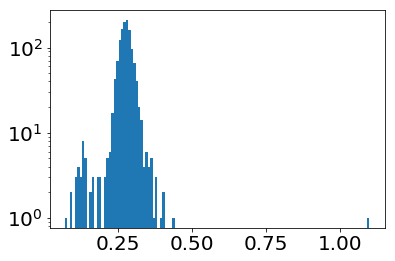

In [12]:
len(laserConstants)
plt.hist(laserConstants, bins=125)
plt.yscale("log")
plt.show()

In [13]:
print("Laser factor:", np.mean(laserConstants))
#laserFactor = 0.2749; #jasons value
laserFactor = np.mean(laserConstants); #calculated from the values brynn sent

Laser factor: 0.27381481481481484


In [14]:
projHist = allEnergies.ProjectionY("_py"+str(1),1,-1,"").Clone()
#projHist->Add(allEnergies.at(0)->ProjectionY(Form("_py%i",0),1,-1,""));
#projHist->Add(allEnergies.at(2)->ProjectionY(Form("_py%i",2),1,-1,""));
tempMean = projHist.GetMean()
tempSig = projHist.GetRMS()
binmax = projHist.GetMaximumBin()
peak = projHist.GetXaxis().GetBinCenter(binmax)
projHist.Fit("gaus","Q","",peak-75, peak+75)

avgPeak = peak;

scaleFactor = targetE / projHist.GetFunction("gaus").GetParameter(1)
print( "average calibration constant is : " , scaleFactor )

for k in range( 1,projHist.GetXaxis().GetNbins() ):
    uncalibratedAllXtals.Fill(projHist.GetXaxis().GetBinCenter(k) * scaleFactor,
                              projHist.GetBinContent(k))

average calibration constant is :  0.35772244444503404


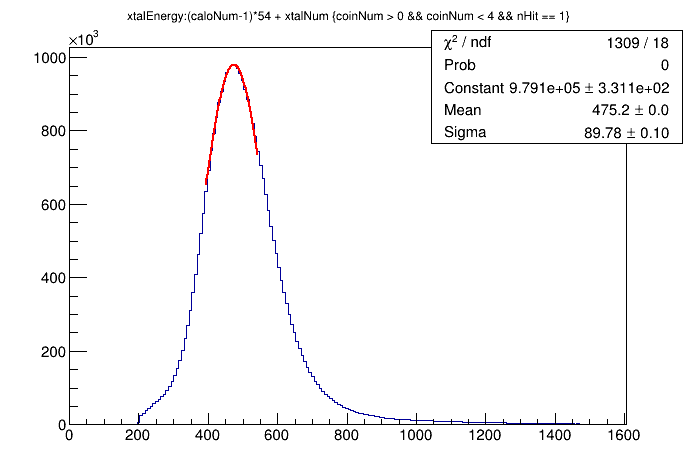

In [15]:
c = r.TCanvas()
projHist.Draw()
projHist.GetXaxis().SetRangeUser(0,1600)
#c.SetLogy()
c.Draw()

---

In [16]:
caloLow = 1
caloHigh = 24

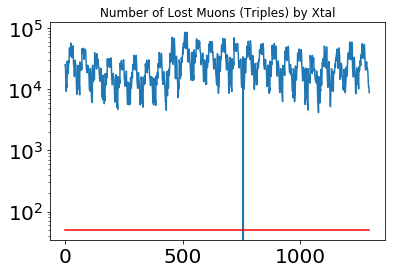

In [17]:
nMuons = []
xtalsBelowThreshold = []
for xIdx in range( (caloLow-1)*54+1 , caloHigh*54+1 ):
    #print("Starting crystal", xIdx)
    #projHist.Clear();
    #projHist=allEnergies.ProjectionY("_py"+str(xIdx*10+0),xIdx,xIdx,"").Clone()
    projHist = allEnergies.ProjectionY("_py",xIdx,xIdx,"").Clone("py")
    nMuons.append(projHist.GetEntries())
    if(projHist.GetEntries() <= 50):
        xtalsBelowThreshold.append(xIdx)
    projHist.Delete()
plt.plot(nMuons)
plt.yscale("log")
plt.plot([0,1296], [50,50], "r")
plt.title("Number of Lost Muons (Triples) by Xtal")
plt.show()

In [18]:
#print(xtalsBelowThreshold)
print("Crystals below threshold of 50 mips:")
for x in xtalsBelowThreshold:
    print("   - calo", int(np.ceil(x/54)), "xtal", x%54-1)
    potentialLostCauses.append(x-1)

Crystals below threshold of 50 mips:
   - calo 15 xtal 2


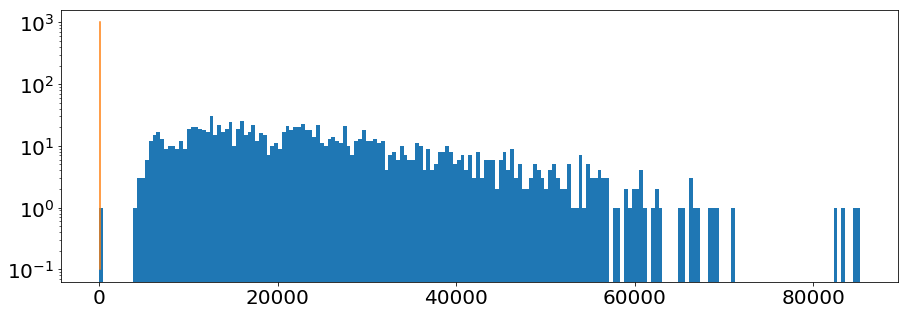

In [19]:
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(nMuons,bins=200)#, range=(0,100))
plt.plot([50,50],[0.1,1000])
plt.yscale("log")
plt.show()

In [20]:
c2 = r.TCanvas("c2","c2",1800,1200);

#for(int xIdx = (caloLow-1)*54 + 1; xIdx <= caloHigh*54; xIdx++){//allEnergies.at(0)->GetXaxis()->GetNbins()
#for xIdx in range( (caloLow-1)*54 + 1, caloHigh*54 ):

energyMinFit = 50.
energyMaxFit = 3000.

allFitHists = [ np.nan for x in range(54*24) ]

scales = [np.nan for x in range(54*24)]

for xIdx in range( (caloLow-1)*54+1 , caloHigh*54+1 ): #this is the bin index, not the crystal number
    print("Starting crystal", xIdx - 1)
    #projHist.Clear();
    #projHist=allEnergies.ProjectionY("_py"+str(xIdx*10+0),xIdx,xIdx,"").Clone()
    projHist = allEnergies.ProjectionY("_py",xIdx,xIdx,"").Clone("py")
    projHist.SetTitle("Xtal "+str(xIdx - 1)+" (calo "+str(int(np.ceil((xIdx-1) / 54)))+", xtal "+str((xIdx - 1) % 54)+")")
    #for(int hit = 1; hit < allEnergies.size(); hit++){
    #    projHist->Add(allEnergies.at(hit)->ProjectionY(Form("_py%i",xIdx*10+hit),xIdx,xIdx,""));
    #}


    #projHist = allEnergies->ProjectionY(Form("_py%i",xIdx),xIdx,xIdx,"");
    #projHist->Rebin(4);

    if(projHist.GetEntries() > 50):
        
        tempMean = projHist.GetMean();
        tempSig = projHist.GetRMS();
        binmax = projHist.GetMaximumBin();
        peak = projHist.GetXaxis().GetBinCenter(binmax);
        peakValue = projHist.GetBinContent(binmax);
        
        while(peakValue < 50):
            #print("hi")
            projHist.Rebin(2);
            binmax = projHist.GetMaximumBin();
            peak = projHist.GetXaxis().GetBinCenter(binmax);
            peakValue = projHist.GetBinContent(binmax);
        #print("continuing")
                                                                
        mini = min([energyMinFit,peak - 60]);
        maxi = max([energyMaxFit,peak + 60]);

        #if(std::find(problemXtals.begin(),problemXtals.end(),xIdx-1)!=problemXtals.end()):
        problemXtal = False
        if( xIdx-1 in problemXtals ):
            problemXtal = True
            #pos = std::find(problemXtals.begin(),problemXtals.end(),xIdx-1) - problemXtals.begin();
            pos = problemXtals.index( xIdx - 1 )
            mini = lower[pos];
            maxi = upper[pos];
            print("     Problem xtal", xIdx - 1)

        #print("fitting")
        
        #define new function in order to set limits
        func = r.TF1("gaus","gaus")
        func.SetParameters(1,500,1)
        func.SetParLimits(0,0,10000000)
        func.SetParLimits(1,100,3000)
        
        for thisMacroSucks in range(2):
            #projHist.Fit("gaus","RQ","",mini, maxi);
            projHist.Fit(func,"RQ","",mini, maxi);
        #if(not problemXtal):
        print("     ",mini, maxi)
        mini = max([energyMinFit,projHist.GetFunction("gaus").GetParameter(1) - 1.5*projHist.GetFunction("gaus").GetParameter(2)]);
        maxi = min([energyMaxFit,projHist.GetFunction("gaus").GetParameter(1) + 1.4*projHist.GetFunction("gaus").GetParameter(2)]);
        #delete projHist->GetFunction("gaus");
        print("     ",mini, maxi)
        #projHist.Fit("gaus","RQ","",mini, maxi);
        projHist.Fit(func,"RQ","",mini, maxi);
        #print("endfitting")
        runningCalo.append(projHist);
        scaleFactor = targetE / projHist.GetFunction("gaus").GetParameter(1);
        #scales.append(scaleFactor);
        scales[xIdx - 1] = scaleFactor
        allFitHists[xIdx - 1] = projHist.Clone("h_"+str(xIdx - 1))
        
        for k in range(1, projHist.GetXaxis().GetNbins() ):
            calibratedXtals.Fill(projHist.GetXaxis().GetBinCenter(k) * scaleFactor,
                                 projHist.GetBinContent(k));

    else:
        print( "Not enough events in channel : " , xIdx) 
        scales[xIdx - 1] = 1.0
        runningCalo.append(projHist);
        allFitHists[xIdx - 1] = projHist.Clone("h_"+str(xIdx - 1))

Starting crystal 0
      50.0 3000.0
      298.87130911562673 607.9216381173164
Starting crystal 1
      50.0 3000.0
      402.8896999196362 540.9259630733907
Starting crystal 2
      50.0 3000.0
      352.52138205937047 566.6374659203921
Starting crystal 3
      50.0 3000.0
      384.2307691227673 512.455640557289
Starting crystal 4
      50.0 3000.0
      296.16789020314013 613.0306280816425
Starting crystal 5
      50.0 3000.0
      408.91581609852676 594.6326583758143
Starting crystal 6
      50.0 3000.0
      343.8840335350562 581.2345551933128
Starting crystal 7
      50.0 3000.0
      364.90996487347434 475.0319781941116
Starting crystal 8
      50.0 3000.0
      292.0935756329566 545.7653486306905
Starting crystal 9
      50.0 3000.0
      391.77897154686866 603.8742320426657
Starting crystal 10
      50.0 3000.0
      361.9507252265854 544.445069509933
Starting crystal 11
      50.0 3000.0
      436.3780887815142 651.339982217509
Starting crystal 12
      50.0 3000.0
      488

In [21]:
print(allFitHists[:5],"...", allFitHists[-5:])

[<ROOT.TH1D object ("h_0") at 0x7fffe32db4a0>, <ROOT.TH1D object ("h_1") at 0x7f583dca9030>, <ROOT.TH1D object ("h_2") at 0x7f583daf0260>, <ROOT.TH1D object ("h_3") at 0x7f583dc9f4b0>, <ROOT.TH1D object ("h_4") at 0x7fffe35a2a90>] ... [<ROOT.TH1D object ("h_1291") at 0x7f583b31b3a0>, <ROOT.TH1D object ("h_1292") at 0x7f583b322330>, <ROOT.TH1D object ("h_1293") at 0x7f583b329530>, <ROOT.TH1D object ("h_1294") at 0x7f583b334d40>, <ROOT.TH1D object ("h_1295") at 0x7f583b337b10>]


Starting calo 1
Starting calo 2
Starting calo 3
Starting calo 4
Starting calo 5
Starting calo 6
Starting calo 7
Starting calo 8
Starting calo 9
Starting calo 10
Starting calo 11
Starting calo 12
Starting calo 13
Starting calo 14
Starting calo 15
Starting calo 16
Starting calo 17
Starting calo 18
Starting calo 19
Starting calo 20
Starting calo 21
Starting calo 22
Starting calo 23
Starting calo 24


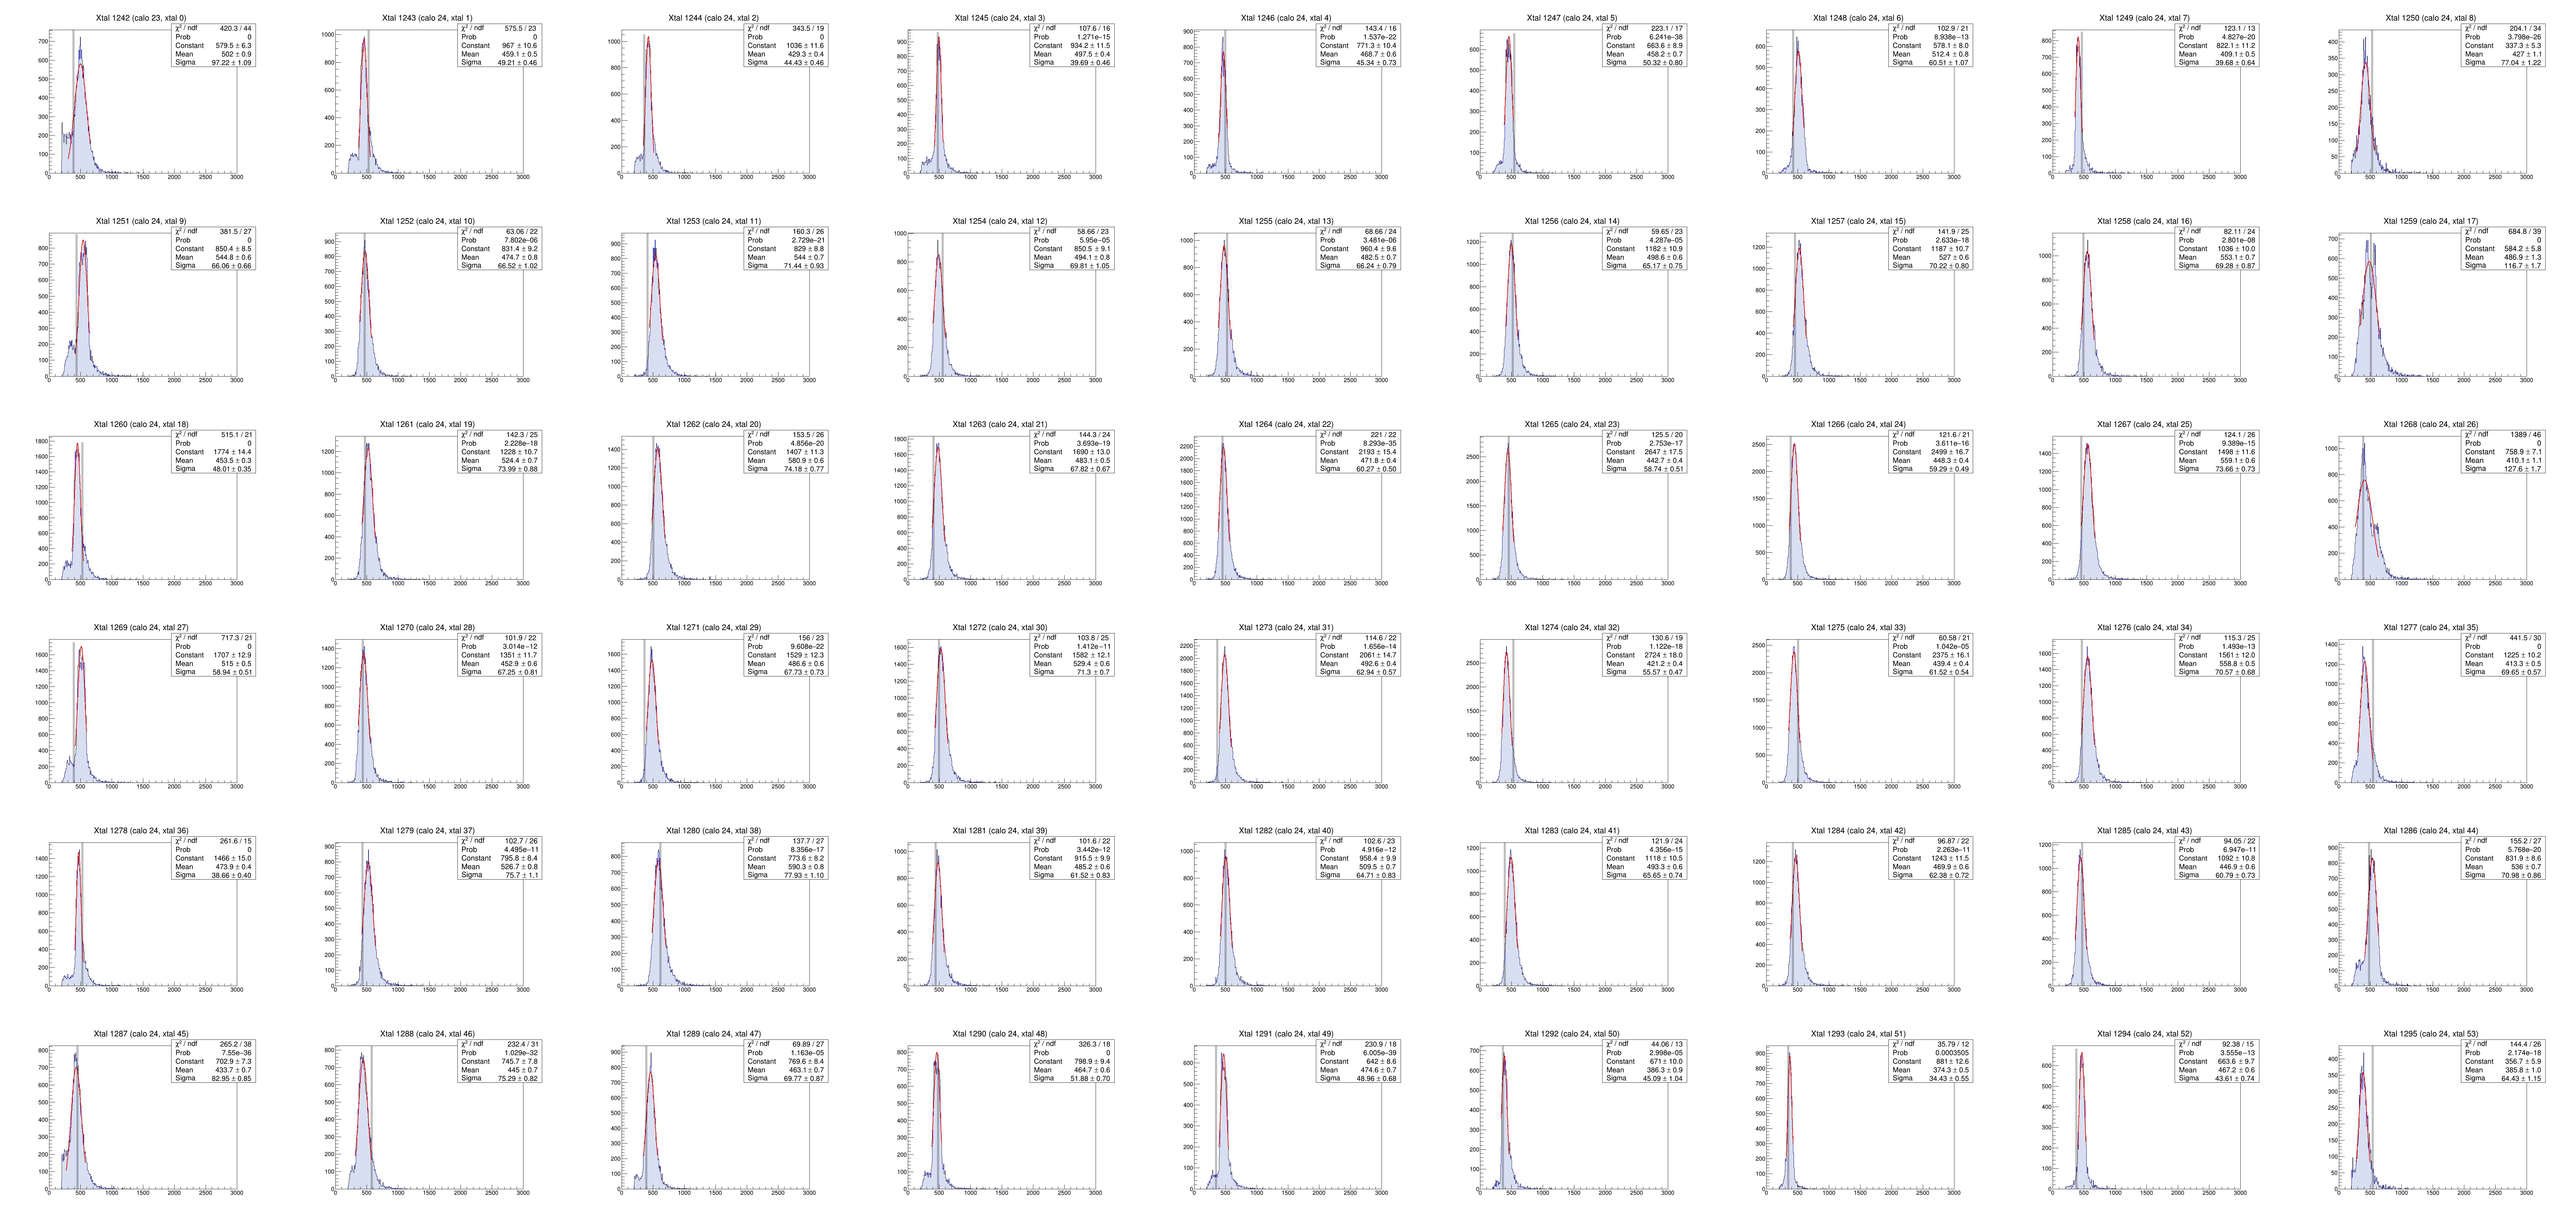

In [22]:
c = r.TCanvas("c","c", 8400, 4000)
c.Divide(9,6)
lines = [-1 for i in range(len(allFitHists))]
for i, h in enumerate(allFitHists):
    #if(i > 3):
    #    break
    #print((i%54) + 1)
    
    c.cd((i%54) + 1 )
    try:
        h.SetFillColorAlpha(38,0.3)
        h.Draw()
        peakValue = h.GetBinContent(h.GetMaximumBin())
        xValue = avgPeak * laserFactor / laserConstants[i]
        line1 = r.TLine( xValue, 0, xValue , 1.05*peakValue);
        line1.SetLineColorAlpha(1,0.25);
        line1.SetLineWidth(7)
        lines[i] = line1.Clone("line_"+str(i))
        lines[i].Draw()
        
    except:
        print("Error: no histogram in entry", i)
        #continue
        

    if( i % 54 == 53):
        print("Starting calo", int(np.ceil(i/54)))
        if(False):
            c.Draw()
            c.Print("./images/AllFits_Calo"+str(int(np.ceil(i/54))).zfill(2)+".png")
            #c.Print("./images/AllFits_Calo"+str(int(np.ceil(i/54))).zfill(2)+".pdf")
            c.Print("./images/AllFits_Calo"+str(int(np.ceil(i/54))).zfill(2)+".root")

c.Draw()

In [23]:
fitPars = [ np.nan for i in range(24*54) ]
for i, h in enumerate(allFitHists):
    try:
        fitPars[i] = (
            h.GetFunction("gaus").GetParameter(0),
            h.GetFunction("gaus").GetParError(0) ,
            h.GetFunction("gaus").GetParameter(1),
            h.GetFunction("gaus").GetParError(1),
            h.GetFunction("gaus").GetParameter(2),
            h.GetFunction("gaus").GetParError(2),
            h.GetFunction("gaus").GetChisquare(),
            h.GetFunction("gaus").GetNDF() 
        )
    except:
        fitPars[i] = [np.nan for x in range(8)]
        print("Error: no histogram in", i)

Error: no histogram in 758


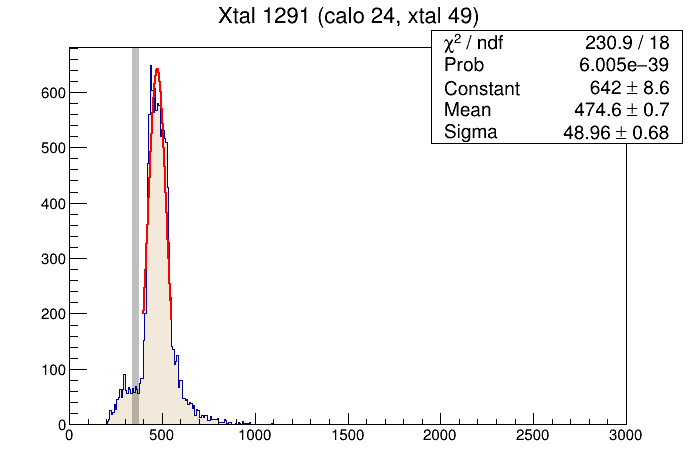

In [24]:
badFits = []
os.system("rm -f ./images/BadFit*")
c = r.TCanvas()
chiSqCut = 8
for i, x in enumerate(fitPars):
    if(x[7] != 0):
        if(x[6]/x[7] > chiSqCut or x[2] < 101):
            allFitHists[i].Draw("")
            allFitHists[i].SetFillColorAlpha(42,0.3)
            lines[i].Draw("SAME")
            c.Draw()
            #c.Print("./images/BadFit_"+str(i).zfill(4)+".png")
            #print("Bad fit in xtal", i)
            badFits.append(i)

In [25]:
print(len(badFits),"bad fits")

335 bad fits


In [26]:
const, constErrs, means, meanErrs, sigs, sigErrs, chiSq, ndf = zip(*fitPars)
xtalNums = [i for i in range(len(const))]

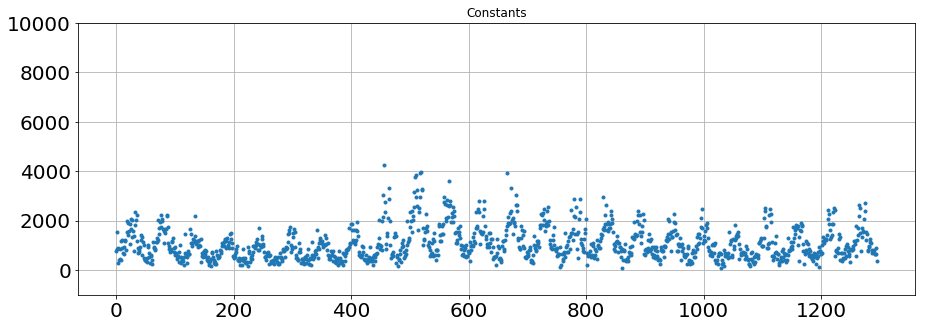

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title("Constants")
plt.errorbar(xtalNums, const, yerr=constErrs, fmt=".")
plt.ylim(-1000,10000)
plt.grid()
plt.show()

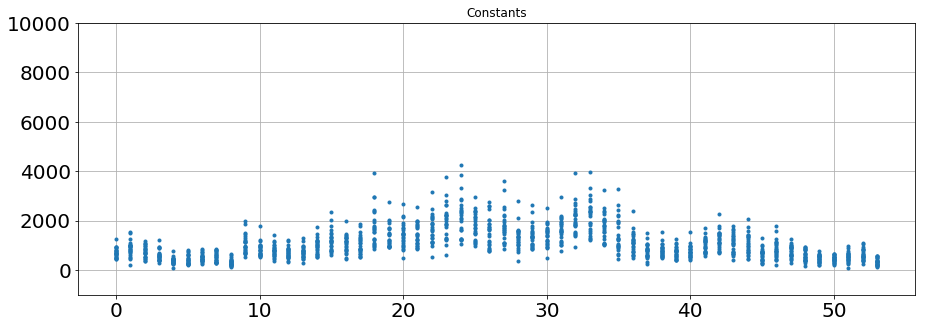

In [28]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title("Constants")
plt.errorbar([x % 54 for x in xtalNums], const, yerr=constErrs, fmt=".")
plt.ylim(-1000,10000)
plt.grid()
plt.show()

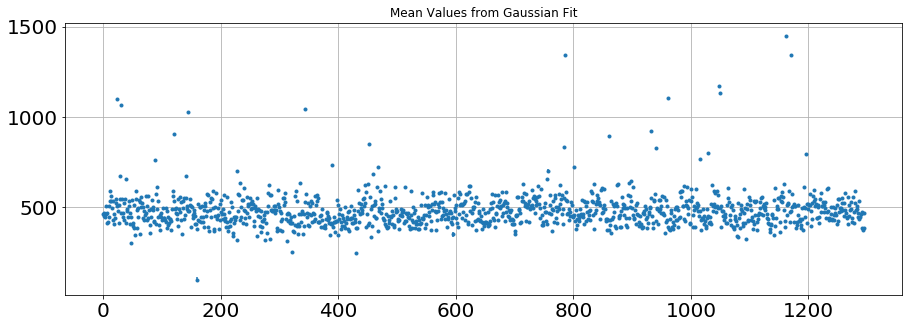

Crystals with high mean values ( > 750 MeV): [24, 31, 88, 121, 145, 344, 452, 785, 786, 861, 932, 941, 961, 1015, 1030, 1048, 1049, 1162, 1171, 1196]


In [29]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(xtalNums, means, yerr=meanErrs, fmt=".")
plt.grid()
plt.title("Mean Values from Gaussian Fit")
plt.show()

highMeans = []
for i, x in enumerate(means):
    if(x > 750):
        highMeans.append(i)
print("Crystals with high mean values ( > 750 MeV):", highMeans)

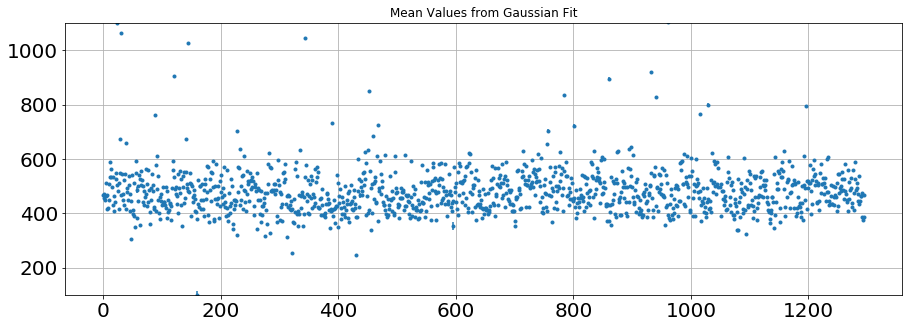

Crystals with high mean values ( > 750 MeV): [24, 31, 88, 121, 145, 344, 452, 785, 786, 861, 932, 941, 961, 1015, 1030, 1048, 1049, 1162, 1171, 1196]


In [30]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(xtalNums, means, yerr=meanErrs, fmt=".")
plt.grid()
plt.title("Mean Values from Gaussian Fit")
plt.ylim(100,1100)
plt.show()

highMeans = []
for i, x in enumerate(means):
    if(x > 750):
        highMeans.append(i)
print("Crystals with high mean values ( > 750 MeV):", highMeans)

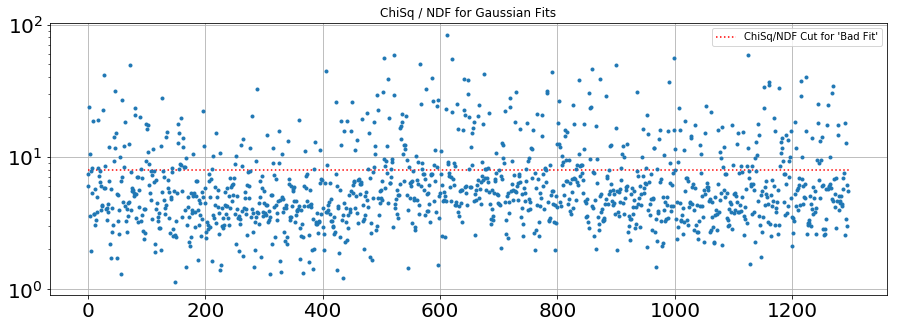

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(xtalNums, [x/(y+0.001) for (x,y) in zip(chiSq, ndf)], yerr=0, fmt=".")
plt.plot([0, 1296],[chiSqCut, chiSqCut], "r:", label="ChiSq/NDF Cut for 'Bad Fit'")
plt.title("ChiSq / NDF for Gaussian Fits")
plt.grid()
plt.legend()
plt.yscale("log")
plt.show()

---

### Many of the bad fids appear to be because of multiple peaks, lets use a peak finding algorithm like TSpectrum to try to identify them

We could also just use a double/triple gaussian fit, which will be plan B if this option fails / doesn't produce convincing results

Warning in <TSpectrum::SearchHighRes>: Peak buffer full
Warning in <TSpectrum::SearchHighRes>: Peak buffer full
Warning in <TSpectrum::SearchHighRes>: Peak buffer full
Warning in <TSpectrum::SearchHighRes>: Peak buffer full
Warning in <TSpectrum::SearchHighRes>: Peak buffer full
Warning in <TSpectrum::SearchHighRes>: Peak buffer full


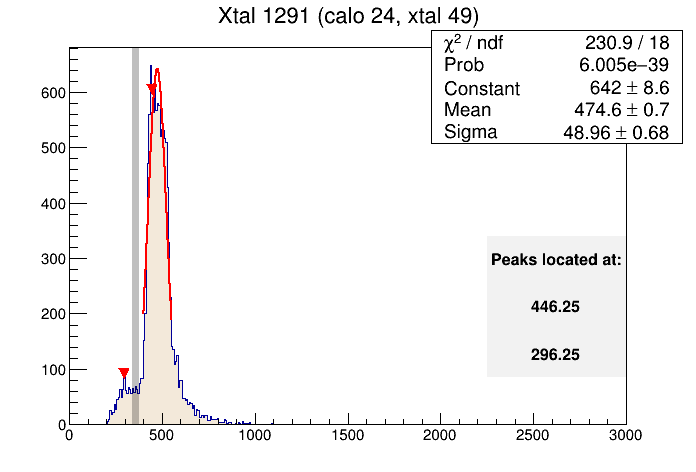

In [32]:
#i = 1007
#i = 1061
#i = 1124

badFitPeaks = []

os.system("rm -f ./images/TSpec*")
for i in badFits:
    c = r.TCanvas()
    allFitHists[i].Draw()
    spec = r.TSpectrum(6) #create a TSpectrum object to search for the peaks with
    npeaks = spec.Search(allFitHists[i], 
                2,      #sigma, see manual
                "",     #options
                0.05)   #threshold as a fraction of highest peak, only look for peaks which are comperable in size.
    #print("Found", npeaks, "peaks")
    #print("Peaks:", [spec.GetPositionX()[x] for x in range(npeaks)])
    spec.Draw("SAME")
    lines[i].Draw("SAME")
    c.Draw()
    #text = r.TPaveText(2000,100,3000,500,"")
    text = r.TPaveText(.7,.2,.9,.5,"NDC")
    text.AddText("Peaks located at:")
    for x in range(npeaks):
        text.AddText(str(spec.GetPositionX()[x]))
    if(npeaks == 0):
        print("ERROR: No peaks found in xtal", i)
        text.AddText("No peaks found")
        potentialLostCauses.append(i)
    text.Draw("SAME")
    
    badFitPeaks.append( (i, 
                         [spec.GetPositionX()[x] for x in range(npeaks)], 
                         [spec.GetPositionY()[x] for x in range(npeaks)]))
    
    #c.Print("./images/TSpectrum_"+str(i).zfill(4)+".png")
    #c.Print("./images/TSpectrum_"+str(i).zfill(4)+".root")

Starting calo 1
Starting calo 2
Starting calo 3
Starting calo 4
Starting calo 5
Starting calo 6
Starting calo 7
Starting calo 8
Starting calo 9
Starting calo 10
Starting calo 11
Starting calo 12
Starting calo 13
Starting calo 14
Starting calo 15
Starting calo 16
Starting calo 17
Starting calo 18
Starting calo 19
Starting calo 20
Starting calo 21
Starting calo 22
Starting calo 23
Starting calo 24


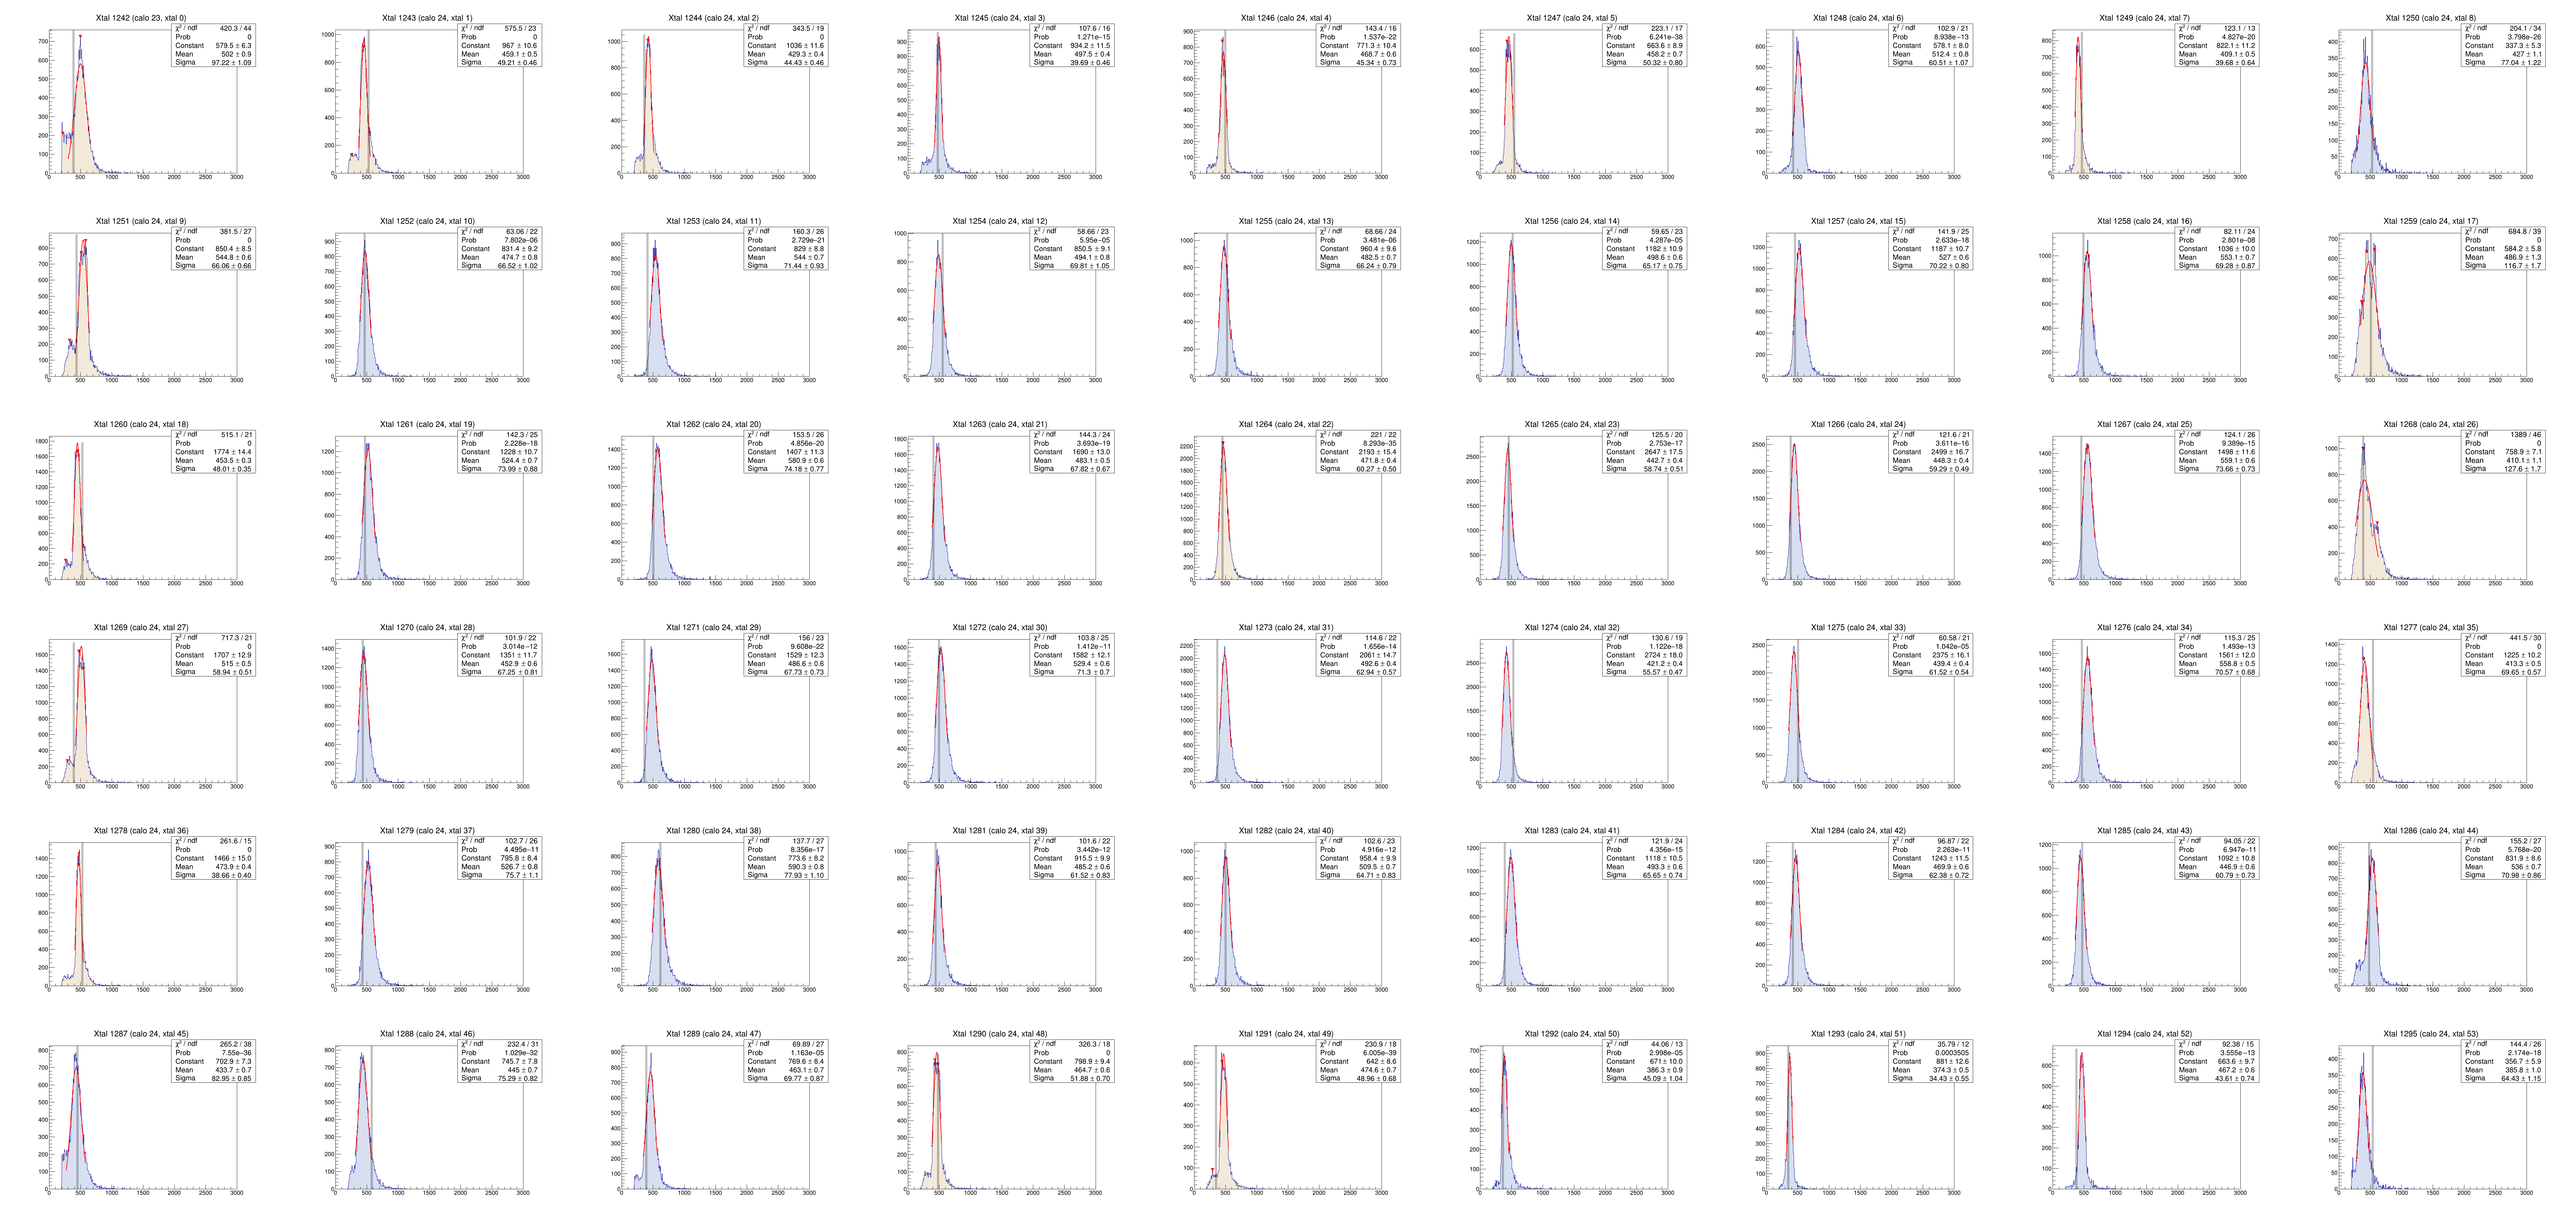

In [33]:
c = r.TCanvas("c","c", 8400, 4000)
c.Divide(9,6)

os.system("rm -f ./images/AllFits_PostTSpectrum_*")

for i, h in enumerate(allFitHists):
    c.cd((i%54) + 1 )
    try:
        #h.SetFillColorAlpha(38,0.3)
        h.Draw()
        lines[i].Draw()
        
    except:
        print("Error: no histogram in entry", i)
        #continue
        

    if( i % 54 == 53):
        print("Starting calo", int(np.ceil(i/54)))
        c.Draw()
        if(False):
            c.Print("./images/AllFits_PostTSpectrum_Calo"+str(int(np.ceil(i/54))).zfill(2)+".png")
            c.Print("./images/AllFits_PostTSpectrum_Calo"+str(int(np.ceil(i/54))).zfill(2)+".root")

In [34]:
#fit function
'''
Double_t fpeaks(Double_t *x, Double_t *par) {
   Double_t result = par[0] + par[1]*x[0];
   for (Int_t p=0;p<npeaks;p++) {
      Double_t norm  = par[3*p+2];
      Double_t mean  = par[3*p+3];
      Double_t sigma = par[3*p+4];
      result += norm*TMath::Gaus(x[0],mean,sigma);
   }
   return result;
}
'''

def fpeaks(x,p):
    result = p[0] + p[1]*x[0]
    #print(len(p), (len(p) -2) / 3 )
    for i in range(int((len(p) -2) /3)):
        norm = p[3*i+2]
        mean = p[3*i+3]
        sigma = p[3*i+4]
        result += norm*r.TMath.Gaus(x[0], mean, sigma)
    return result

---

### Now lets use these peaks to decide the energy calibration for these crystals.

Initial plan is to take the largest amplitude peak if no other peak is a certain amount (maybe 75%?). If there are two+ peaks of comperable amplitude, then take the higher energy of the them (and flag for manual review).

In [35]:
peakCutoffFactor = 0.75

xtalsForReview = []
newLines = [-1 for x in range(54*24)]

os.system("rm -f ./images/Review*")

for j, (i, peakX, peakY) in enumerate(badFitPeaks):
    print("Starting xtal", i )
    if(len(peakY) > 0):
        maxPeak = max(peakY)
        maxPeakIndex = peakY.index(maxPeak)
        otherPeaks = []
        for k, pk in enumerate(peakY):
            if(pk < maxPeak and pk > peakCutoffFactor*maxPeak):
                otherPeaks.append(k)
        if(len(otherPeaks) > 0):
            #for peaks in [maxPeakIndex]+[otherPeaks]:
            #    if(peakX[peak] > max(peakX)):
            #        finalPeak = 
            finalPeak = 0 #peakX[ peakX.index(max(peakX)) ]
            for k, pxk in enumerate(peakX):
                if(peakY[k] > peakCutoffFactor*maxPeak):
                    if(pxk > finalPeak): 
                        finalPeak = pxk
            print("     *** FLAG FOR REVIEW ***")
            xtalsForReview.append(i)
        else:
            finalPeak = peakX[maxPeakIndex]
        print("     Final peak for xtal", i, "=", finalPeak)
        print("    ", 
              finalPeak, 
              otherPeaks, 
              peakX,
              peakY )
        
        line1 = r.TLine( finalPeak, 0, finalPeak , 1.05*maxPeak);
        line1.SetLineColorAlpha(1,0.25);
        line1.SetLineWidth(7)
        newLines[i] = line1.Clone("line_"+str(i))
        c = r.TCanvas()
        allFitHists[i].Draw()
        newLines[i].Draw("SAME")
        c.Print("./images/ReviewHist_"+str(i).zfill(4)+".png")
        
        scaleFactor = targetE / finalPeak
        scales[i] = scaleFactor
        
    else:
        print("     No peaks found")
        potentialLostCauses.append(i)

Starting xtal 2
     Final peak for xtal 2 = 446.25
     446.25 [] [446.25, 236.25] [948.0, 133.0]
Starting xtal 4
     *** FLAG FOR REVIEW ***
     Final peak for xtal 4 = 506.25
     506.25 [1] [506.25, 431.25, 303.75, 603.75] [345.0, 265.0, 141.0, 105.0]
Starting xtal 7
     Final peak for xtal 7 = 408.75
     408.75 [] [408.75] [793.0]
Starting xtal 9
     *** FLAG FOR REVIEW ***
     Final peak for xtal 9 = 528.75
     528.75 [1] [528.75, 476.25, 341.25] [996.0, 967.0, 226.0]
Starting xtal 17
     *** FLAG FOR REVIEW ***
     Final peak for xtal 17 = 498.75
     498.75 [1] [401.25, 498.75, 326.25] [899.0, 779.0, 434.0]
Starting xtal 18
     Final peak for xtal 18 = 401.25
     401.25 [] [401.25] [1793.0]
Starting xtal 26
     Final peak for xtal 26 = 401.25
     401.25 [] [401.25] [1817.0]
Starting xtal 27
     *** FLAG FOR REVIEW ***
     Final peak for xtal 27 = 536.25
     536.25 [0] [476.25, 536.25, 318.75] [1796.0, 1906.0, 245.0]
Starting xtal 29
     Final peak for xtal 29 =

Info in <TCanvas::Print>: png file ./images/ReviewHist_0002.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0004.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0007.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0009.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0017.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0018.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0026.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0027.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0029.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0036.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0044.png has been created
Info in <TCanvas::Print>: png file ./images/ReviewHist_0045.png has been created
Info in <TCanvas::Print>: pn

In [36]:
print("Review these", len(xtalsForReview),"xtals:", xtalsForReview)
print("Potential lost causes:", potentialLostCauses)

Review these 71 xtals: [4, 9, 17, 27, 48, 63, 72, 81, 90, 111, 154, 155, 156, 157, 158, 218, 252, 263, 288, 305, 370, 441, 449, 490, 595, 596, 611, 621, 629, 642, 650, 654, 675, 707, 719, 720, 751, 755, 757, 791, 802, 810, 813, 827, 854, 868, 873, 899, 936, 953, 1008, 1027, 1035, 1043, 1052, 1061, 1077, 1078, 1081, 1124, 1138, 1151, 1182, 1183, 1189, 1196, 1224, 1251, 1259, 1269, 1290]
Potential lost causes: [758]


---

### Some crystals may fail even after this step. These we can set manually

[758]


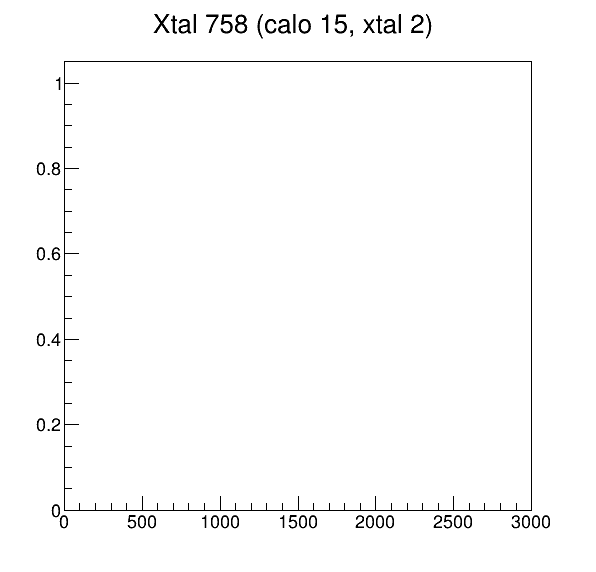

In [37]:
potentialLostCauses = list(set(potentialLostCauses))
print(potentialLostCauses)
c = r.TCanvas("c","c",600*len(potentialLostCauses), 600)
c.Divide(len(potentialLostCauses))
for i, x in enumerate(potentialLostCauses):
    c.cd(i+1)
    allFitHists[x].Draw()
c.Draw()

In [38]:
lostCauses = []

In [39]:
print(lostCauses)
for i, const in lostCauses:
    scaleFactor = targetE / const
    scales[i] = scaleFactor

[]


---

In [40]:
for i, x in enumerate(allFitHists):
    if("ROOT" not in str(type(x))):
        print(i,x)

In [41]:
calibratedXtalsFinal = calibratedXtals.Clone("calibratedXtalsFinal")
calibratedXtalsFinal.Reset()
calibratedXtalsFinal.SetLineColor(3)
for i, projHist in enumerate(allFitHists):
    scaleFactor = scales[i]
    for k in range(1, projHist.GetXaxis().GetNbins() ):
        calibratedXtalsFinal.Fill(projHist.GetXaxis().GetBinCenter(k) * scaleFactor,
                             projHist.GetBinContent(k));

Info in <TCanvas::Print>: png file ./images/calibrationComparison.png has been created


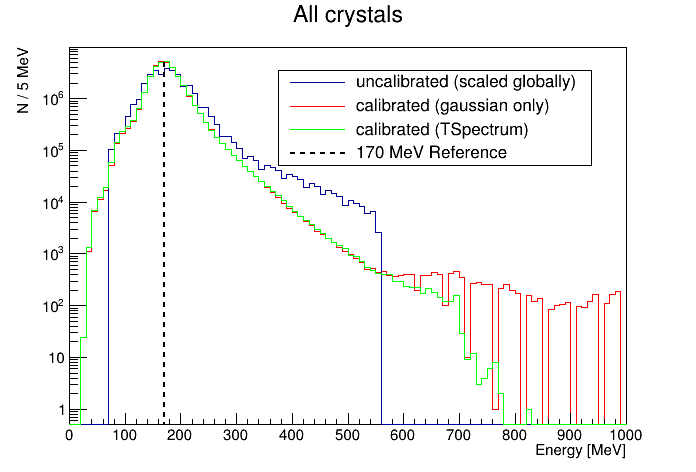

In [42]:
calibratedXtals.SetLineColor(2);
c1 = r.TCanvas("c1","c1",700,500);
leg1 = r.TLegend(0.4,0.65,0.85,0.85);
leg1.AddEntry(uncalibratedAllXtals,"uncalibrated (scaled globally)","l");
leg1.AddEntry(calibratedXtals,"calibrated (gaussian only)","l");
leg1.AddEntry(calibratedXtalsFinal,"calibrated (TSpectrum)","l");
calibratedXtals.Draw("hist");
uncalibratedAllXtals.Draw("hist same");
calibratedXtalsFinal.Draw("hist same");


line1 = r.TLine( 170., 0, 170. , 5*10**6);
line1.SetLineColorAlpha(1,1);
line1.SetLineWidth(2)
line1.SetLineStyle(7)
line1.Draw("SAME")
leg1.AddEntry(line1,"170 MeV Reference","l");

leg1.Draw();

c1.Draw()
c1.SetLogy()
c1.Print("./images/calibrationComparison.png");

In [43]:
print("Gaussian Mean:", calibratedXtals.GetMean(1))
print("TSpectrum Mean:", calibratedXtalsFinal.GetMean(1))

Gaussian Mean: 175.9436974778875
TSpectrum Mean: 175.727457567217


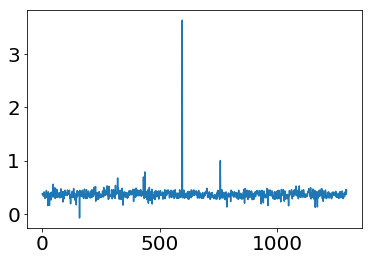

In [44]:
#brynnScales = pandas.read_csv("./brynnConstants.txt", header=None)
brynnScales = pandas.read_csv("./brynnConstants_Nov27.txt", header=None)
brynnScales.head()
plt.plot(brynnScales[0])
plt.show()

In [45]:
brynnScales.loc[brynnScales[0] > 0.6]

,0
321,0.672
431,0.691
437,0.786
596,3.637
758,1.000


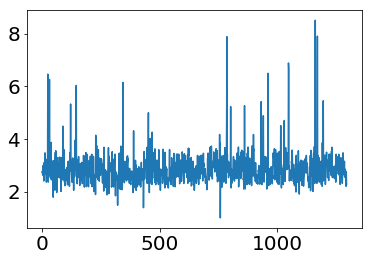

In [46]:
plt.plot([1/x for x in scales])
plt.show()

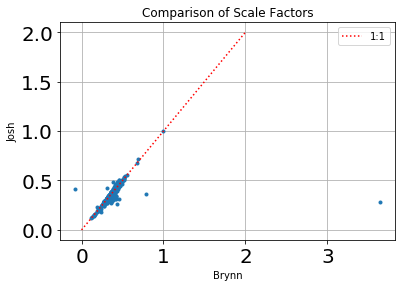

In [47]:
noint()
plt.plot(brynnScales[0], scales,".")
plt.title("Comparison of Scale Factors")
plt.xlabel("Brynn")
plt.ylabel("Josh")
#plt.ylim(0,2)
#plt.xlim(0,2)
plt.plot([0,2],[0,2],"r:",label="1:1")
plt.legend()
plt.grid()
plt.show()

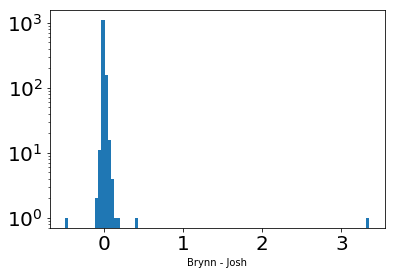

In [48]:
plt.hist([x-y for (x,y) in zip(brynnScales[0], scales)],bins=100)#,range=(-0.1,0.1))
plt.xlabel("Brynn - Josh")
plt.yscale("log")
plt.show()

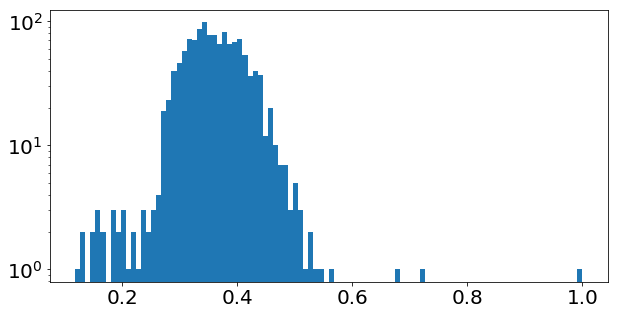

In [49]:
fig,ax = plt.subplots(figsize=(10,5))
#plt.hist([x for (x,y) in zip(brynnScales[0], scales)],bins=100,range=(0,2), alpha=0.3)
plt.hist([y for (x,y) in zip(brynnScales[0], scales)],bins=100)#,range=(0,2), alpha=0.3)
plt.yscale("log")
plt.show()

In [50]:
for i, x in enumerate(scales):
    if(x > 100):
        print(i, np.ceil(i/54), i %54, x)


****************************************
Minimizer is Linear
Chi2                      =      273.811
NDf                       =         1294
p0                        =      1.21029   +/-   0.0610594   
p1                        =     0.437689   +/-   0.0159331   


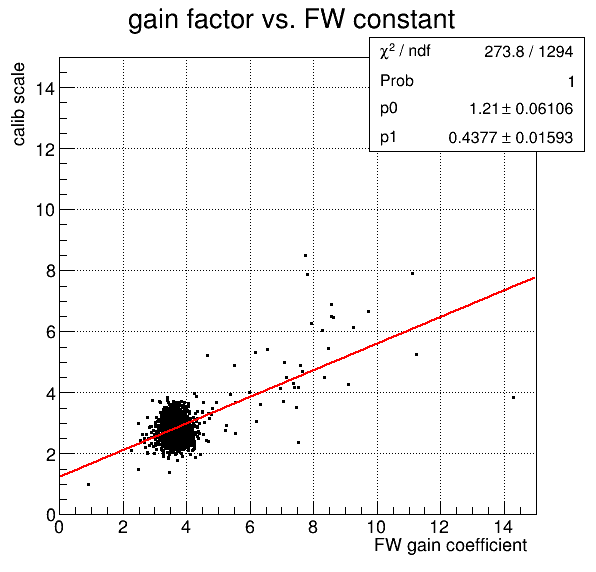

In [51]:
calibGain = r.TGraph();
for k in range(0, len(laserConstants)):
    #if(k%100 == 0):
    #    print("point", k)
    #//std::cout<< "laser "<<laserConstants.at(k) << std::endl;
    #//std::cout<< "calib "<<scales.at(k) << std::endl;
    calibGain.SetPoint(k, 1.0 / laserConstants[k], 1.0 / scales[k]);

c3 = r.TCanvas("c3","c3",600,600);
calibGain.SetTitle("gain factor vs. FW constant; FW gain coefficient; calib scale");
calibGain.SetMarkerStyle(7);
calibGain.Draw("apz");
calibGain.Fit("pol1")
calibGain.GetXaxis().SetRangeUser(0,15)
calibGain.GetYaxis().SetRangeUser(0,15)
c3.SetGrid()
c3.Draw();


In [52]:
for xtal, value in enumerate(scales):
    if(value == 1.0 or value == np.nan):
        print("Problem xtal:", xtal, "( calo", int(np.ceil(xtal/54)), "xtal", xtal%54,")")

Problem xtal: 758 ( calo 15 xtal 2 )


In [53]:
fclOut = open("./mipEnergyCalibration29927.fcl","w")

print("BEGIN_PROLOG")
print("absolute_calibration_constants : {")
fclOut.write("BEGIN_PROLOG"+"\n")
fclOut.write("absolute_calibration_constants : {"+"\n")
#for(int calo = 1; calo <= 24; calo++){
for calo in range(1,25):
    #std::cout<<Form("\tcalo%i : {",calo)<<std::endl;
    print("\t"+"calo"+str(calo))
    fclOut.write("\t"+"calo"+str(calo)+" : {"+"\n")
    #for(int xtal = 0; xtal < 54; xtal++){
    for xtal in range(54):
        #std::cout<<Form("\t\txtal%i : %0.3f",xtal,scales.at(54*(calo-1)+xtal))<<std::endl;
        print("\t"+"\t"+"xtal"+str(xtal)+" : "+str(round(scales[54*(calo-1)+xtal],4)))
        fclOut.write("\t"+"\t"+"xtal"+str(xtal)+" : "+str(round(scales[54*(calo-1)+xtal],4))+"\n")
    print("\t"+"}")
    fclOut.write("\t"+"}"+"\n")
    #std::cout<<"\t}"<<std::endl;
print("}")
fclOut.write("}"+"\n")
print("END_PROLOG")
fclOut.write("END_PROLOG")

fclOut.close()

BEGIN_PROLOG
absolute_calibration_constants : {
	calo1
		xtal0 : 0.3648
		xtal1 : 0.3602
		xtal2 : 0.381
		xtal3 : 0.3788
		xtal4 : 0.3358
		xtal5 : 0.3331
		xtal6 : 0.3644
		xtal7 : 0.4159
		xtal8 : 0.4056
		xtal9 : 0.3215
		xtal10 : 0.38
		xtal11 : 0.3179
		xtal12 : 0.2881
		xtal13 : 0.3014
		xtal14 : 0.3184
		xtal15 : 0.3419
		xtal16 : 0.3177
		xtal17 : 0.3409
		xtal18 : 0.4237
		xtal19 : 0.3673
		xtal20 : 0.3858
		xtal21 : 0.3095
		xtal22 : 0.3232
		xtal23 : 0.3361
		xtal24 : 0.1548
		xtal25 : 0.3526
		xtal26 : 0.4237
		xtal27 : 0.317
		xtal28 : 0.2521
		xtal29 : 0.317
		xtal30 : 0.3643
		xtal31 : 0.1598
		xtal32 : 0.312
		xtal33 : 0.3791
		xtal34 : 0.3623
		xtal35 : 0.3946
		xtal36 : 0.3409
		xtal37 : 0.3116
		xtal38 : 0.2584
		xtal39 : 0.4085
		xtal40 : 0.3552
		xtal41 : 0.3441
		xtal42 : 0.3796
		xtal43 : 0.3163
		xtal44 : 0.3461
		xtal45 : 0.3942
		xtal46 : 0.3686
		xtal47 : 0.5597
		xtal48 : 0.3514
		xtal49 : 0.3149
		xtal50 : 0.4263
		xtal51 : 0.411
		xtal52 : 0.3319
		xtal53

---

### Quick comparison to run2 values

In [54]:
run2ScalesByCalo = [[np.nan for i in range(54)] for j in range(24) ]
run2Scales = []
with open("./data/mipEnergyCalibration23609.fcl") as file:
    for line in file:
        if("calo" in line):
            calo = int(line.split("calo")[1].split(" ")[0])
        if("xtal" in line):
            xtal = int(line.split("xtal")[1].split(" ")[0])
            constant = float(line.split("xtal")[1].split(" ")[2][:-1])
            run2ScalesByCalo[calo-1][xtal] = constant
            run2Scales.append(constant)

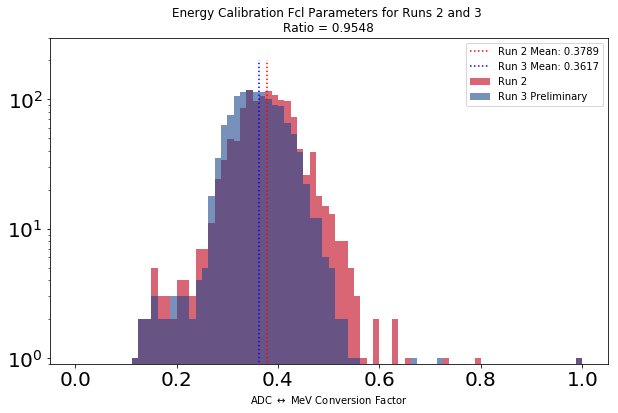

In [55]:
fig,ax = plt.subplots(figsize=(10,6))
plotbins = 80
plotrange = (0,1)

plt.hist(run2Scales,label="Run 2",bins=plotbins, range=plotrange, alpha=0.6, color="xkcd:scarlet")
plt.plot([np.mean(run2Scales), np.mean(run2Scales)], [0.01,200], "r:",label="Run 2 Mean: "+str(round(np.mean(run2Scales),4)))

plt.hist(scales, label="Run 3 Preliminary",bins=plotbins, range=plotrange, alpha=0.6, color="xkcd:cobalt")
plt.plot([np.mean(scales), np.mean(scales)], [0.01,200], "b:",label="Run 3 Mean: "+str(round(np.mean(scales),4)))


plt.title("Energy Calibration Fcl Parameters for Runs 2 and 3 \n"+"Ratio = "+str(round(np.mean(scales)/np.mean(run2Scales),4)))
plt.xlabel(r"ADC $\leftrightarrow$ MeV Conversion Factor")
#plt.ylabel("N")

plt.ylim(0.9,300)

plt.legend()

plt.yscale("log")
plt.show()

In [56]:
print("Mean run2:", np.mean(run2Scales))
print("Mean run3:", np.mean(scales))
print("Ratio:", np.mean(scales)/np.mean(run2Scales))

Mean run2: 0.3788672839506173
Mean run3: 0.36172381974964757
Ratio: 0.9547507400950348


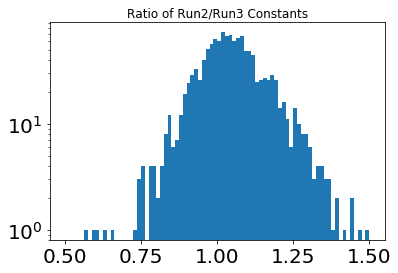

In [57]:
diffScales = [x/y for x,y in zip(run2Scales, scales)]
plt.hist(diffScales,bins=80,range=(0.5,1.5))
plt.yscale("log")
plt.title("Ratio of Run2/Run3 Constants")
plt.show()

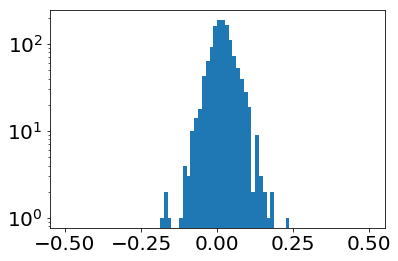

In [58]:
diffScales = [x-y for x,y in zip(run2Scales, scales)]
plt.hist(diffScales,bins=80,range=(-.5,.5))
plt.yscale("log")
plt.show()

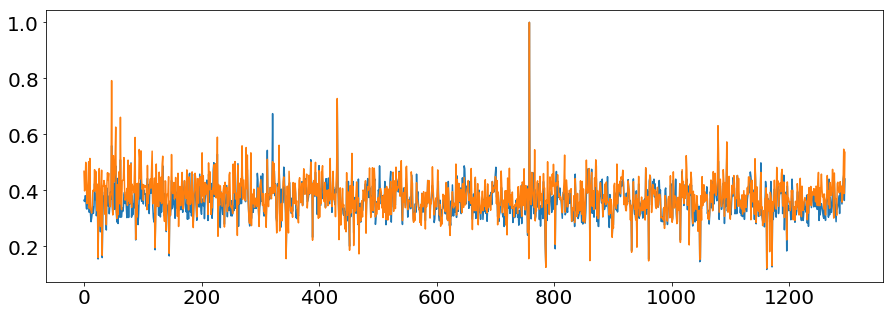

In [59]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(scales)
plt.plot(run2Scales)
plt.show()